In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *
from helpers_similarity import *
from helpers_optimization import *
from scipy.optimize import minimize
import time


In [3]:
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0
lambda_reg = 0.1
parameters = {}


In [4]:
Y = np.load('data/tensor_Y.npy')
n_users, n_items, _ = Y.shape
print("Shape of the tensor Y: ", Y.shape)
Y[0]

Shape of the tensor Y:  (50, 73, 73)


array([[ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [5]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): # tha larger alpha, the flatter and noisier the sigmoid is !! read abt it !!
    # this method breaks down when n_users*n_movies is large (e.g., more than a million).
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff


In [6]:
def pairwise_comparisons(P):
    
    Y = np.random.binomial(n=1, p=P, size=P.shape) 
    Y = np.where(Y == 0, -1, Y)
    
    return Y

In [7]:
def hinge_loss(x):
    return np.maximum(0, 1 - x)**2 

In [8]:
def sum_loss(U, V, Y):
    n, m, _ = Y.shape
    loss = 0
    for j in range(m):
        v = V[:,j] - V.T
        x = np.dot(v, U)
        loss += np.sum(hinge_loss(Y[:,j]*x.T)[:,:j])
    return loss

In [9]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    U = U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg

In [10]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg

## Alternating Minimization of U and V

Explain what we're doing here

In [11]:
def initialize_parameters(Y, sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg):  

    U_init = np.random.normal(mu, sigma_u, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_v, (d_dims, n_movies))   
   
    #parameters['P'] = P
    parameters['Y'] = Y
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_reg'] = lambda_reg

In [12]:
def update_parameters(d_dim, n_users, n_movies):
    U_prev = parameters['U_result']
    V_prev = parameters['V_result']
    Y = parameters['Y']

    U_prev = U_prev.reshape((d_dim, n_users))
    V_prev = V_prev.reshape((d_dim, n_movies))

    U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    
    U_result = U_result.x.reshape((d_dim, n_users))
    V_result = V_result.x.reshape((d_dim, n_movies))
    
    parameters['U_result'] = U_result
    parameters['V_result'] = V_result

In [13]:
def loss(d_dim, n_users, n_movies):
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    Y = parameters['Y']
    lambda_reg = parameters['lambda_reg']

    loss_u = loss_U(U_result, Y, V_result, lambda_reg, d_dim, n_users) /(d_dim*n_users) # normalize by n_users or d_dim*n_users ??
    loss_v = loss_V(V_result, Y, U_result, lambda_reg, d_dim, n_movies) /(d_dim*n_movies)
    
    return loss_u, loss_v


In [14]:
def orth_procrustes(X, Y, len_X):
    R, scale = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')/np.sqrt(len_X)
    
    return rss

In [15]:
def compare_results(n_users):
    Y = parameters['Y']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    X_result = np.matmul(U_result.T, V_result)
    P_result, _ = generate_P_BT_Luce(X_result, n_users)
    Y_result = pairwise_comparisons(P_result)
    diff_norm_Y = np.linalg.norm(Y - Y_result)
    
    return diff_norm_Y


In [16]:
def alt_minimization_U_V(Y, d_dims, n_users, n_movies):
    initialize_parameters(Y, sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg) 
    loss_u_vals = []
    loss_v_vals = []
    #while True:
    for i in range(25): # 50
        if len(loss_u_vals) > 2:
            if np.abs(loss_u_vals[-1] - loss_u_vals[-2]) < 0.1:
                break
        update_parameters(d_dims, n_users, n_movies)

        loss_u, loss_v = loss(d_dims, n_users, n_movies)
        loss_u_vals.append(loss_u)
        loss_v_vals.append(loss_v) 
        if i % 10 == 0:
            print(f'loss_u: {loss_u}, loss_v: {loss_v}')      
                
    diff_norm_Y = compare_results(n_users)
    
    return diff_norm_Y, loss_u_vals, loss_v_vals


In [21]:
def plot_results(data):

    df = pd.DataFrame(data, columns = ['D', 'diff_Y']) # remove N and M

    # plot D as a function of diff_Y
    plt.plot(df['D'], df['diff_Y'], marker='o')
    plt.set_xlabel('D')
    plt.set_ylabel('diff_Y')
    plt.set_title('Variation of diff_Y for varying D')

    plt.show()

In [18]:
data = []
d_dims = [2, 5, 10]
print(f'N: {n_users}, M: {n_items}')

for i in range(len(d_dims)):

    diff_Y, loss_u_vals, loss_v_vals = alt_minimization_U_V(Y, d_dims[i], n_users, n_items)
    row= [d_dims[i], diff_Y]
    data.append(row)


N: 50, M: 73


/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_76698/1314612138.py:9: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_76698/1314612138.py:10: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')


loss_u: 1316.2662901792041, loss_v: 901.5360347255736
loss_u: 1317.129234176137, loss_v: 902.1432232199084
loss_u: 1317.51300920212, loss_v: 902.4106088262434
loss_u: 525.9247239810039, loss_v: 360.22704045726255
loss_u: 525.7794100288121, loss_v: 360.1248374123676
loss_u: 525.8321344005254, loss_v: 360.16007387227774
loss_u: 262.91188228326206, loss_v: 180.08563080595258


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

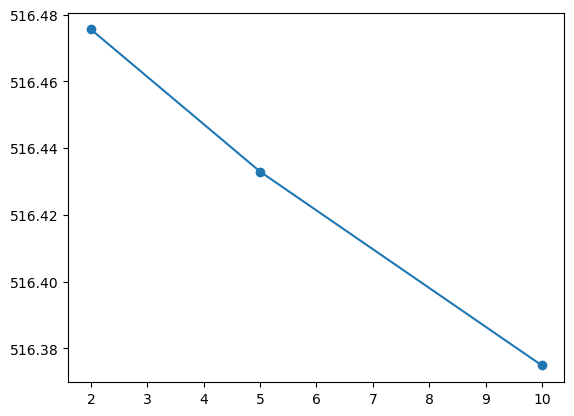

In [22]:
plot_results(data)

In [49]:
plt.savefig('results_optimization.pdf')

<Figure size 640x480 with 0 Axes>